In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [13]:
#파일 읽기
cmo_df = pd.read_excel('./CMO-Historical-Data-Monthly_prefix.xlsx', sheet_name='Monthly Prices', index_col=0)
lng_df = pd.read_excel('./월간 액화천연가스 수입.xlsx', index_col=0)
#전처리
cmo_df = cmo_df.drop(cmo_df.index[0])
lng_df.drop(columns=['수입액(백만 USD)', '수입량(1,000 톤)'], inplace=True)

In [14]:
#데이터 프레임 병합
source_df = pd.concat([cmo_df, lng_df], axis=1)
source_df

,"Crude oil, Dubai","Coal, Australian","Natural gas, US","Natural gas, Europe","Liquefied natural gas, Japan",U$/MT
2002-01-01,18.291818,27.35,2.25,3.06,4.21,223.748956
2002-02-01,18.911053,28.1,2.31,3.03,4.12,221.859624
2002-03-01,22.8545,27.8,3.03,2.97,3.99,213.337581
2002-04-01,24.405455,27.0875,3.42,2.81,3.96,207.203693
2002-05-01,24.585217,26.875,3.49,2.83,4.01,209.574109
...,...,...,...,...,...,...
2022-04-01,102.68,310.85,6.5306,32.204187,16.287524,695.031958
2022-05-01,108.32,371.86,8.1373,29.170723,16.679091,723.310581
2022-06-01,115.73,374.08,7.674,33.557731,15.533921,762.065675
2022-07-01,106.48,402.2,7.2561,51.33003,18.880754,1032.475321


In [16]:
# 훈련 데이터와 테스트 데이터로 분리
train_start, train_end = '2002-01-01', '2018-12-01'
test_start, test_end = '2019-01-01', '2022-08-01'
train = source_df.loc[train_start:train_end, :]
test = source_df.loc[test_start:test_end, :]

# 종속변수와 독립변수 나누기
X_train = train[['Crude oil, Dubai', 'Coal, Australian', 'Natural gas, US',	'Natural gas, Europe', 'Liquefied natural gas, Japan']]
y_train = train[['U$/MT']]
X_test = test[['Crude oil, Dubai', 'Coal, Australian', 'Natural gas, US',	'Natural gas, Europe', 'Liquefied natural gas, Japan']]
y_test = test[['U$/MT']]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# 데이터 전처리
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps, :])
        ys.append(y[i+time_steps, 0])
    return np.array(Xs), np.array(ys)

time_steps = 1

X_train_processed, y_train_processed = create_dataset(X_train_scaled, y_train_scaled, time_steps)
X_test_processed, y_test_processed = create_dataset(X_test_scaled, y_test_scaled, time_steps)

# 모델 학습
model = Sequential()
model.add(LSTM(units=10, input_shape=(time_steps, X_train_processed.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train_processed, y_train_processed, epochs=500, batch_size=20, verbose=1)
     


Epoch 1/500


2023-08-07 22:29:54.769334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-07 22:29:54.770081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-07 22:29:54.770958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 1s 2ms/step - loss: 0.2275
Epoch 2/500
11/11 [==============================] - 0s 1ms/step - loss: 0.1897
Epoch 3/500
11/11 [==============================] - 0s 1ms/step - loss: 0.1544
Epoch 4/500
11/11 [==============================] - 0s 2ms/step - loss: 0.1202
Epoch 5/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0909
Epoch 6/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0661
Epoch 7/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0460
Epoch 8/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0324
Epoch 9/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0231
Epoch 10/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0185
Epoch 11/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0158
Epoch 12/500
11/11 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 13/500
11/11 [=============================

In [17]:
# 예측
y_train_predicted = model.predict(X_train_processed)
y_test_predicted = model.predict(X_test_processed)

# 스케일링 복원
y_train_predicted = scaler_y.inverse_transform(y_train_predicted)
y_test_predicted = scaler_y.inverse_transform(y_test_predicted)
y_train_actual = scaler_y.inverse_transform(y_train_processed.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test_processed.reshape(-1, 1))

# MAPE 계산
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mape(y_train_actual, y_train_predicted)
test_mape = mape(y_test_actual, y_test_predicted)
print('Train MAPE:', train_mape)
print('Test MAPE:', test_mape)
     

2/2 [==============================] - 0s 1ms/step
Train MAPE: 4.403059454502753
Test MAPE: 7.520565226735938


2023-08-07 22:30:25.472196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-07 22:30:25.473036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-07 22:30:25.474011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

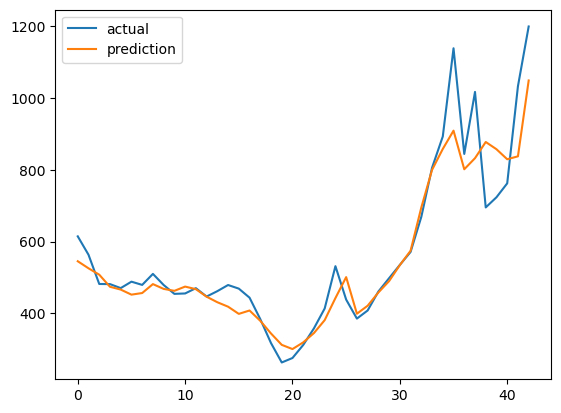

In [18]:
import matplotlib.pyplot as plt
#test_mape = mape(y_test_actual, y_test_predicted)
plt.plot(y_test_actual, label='actual')
plt.plot(y_test_predicted, label='prediction')
plt.legend()
plt.show()
     